# R2D2
訓練不起來

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from tqdm.auto import tqdm,trange
from pathlib import Path
import pandas as pd
import torch.nn.utils.prune as prune
import numpy as np
import random
import learn2learn as l2l
import pickle
import matplotlib.pyplot as plt

/home/samuel/.conda/envs/meta/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
kways = 5 
train_shots =5
train_querys =6
val_shots =5
val_querys =15
test_shots =5
test_querys =5

In [4]:
with open("./data/test.pkl",'rb') as f:
    test_data = pickle.load(f)
with open("./data/train.pkl",'rb') as f:
    train_data = pickle.load(f)
with open("./data/validation.pkl",'rb') as f:
    val_data = pickle.load(f)

In [5]:
train_data['images'].shape

(38400, 3, 84, 84)

In [6]:
val_data['images'].shape

(9600, 3, 84, 84)

# Task augmentation

In [7]:
%%time
images = train_data["images"]
labels = train_data["labels"]
num_labels = np.unique(labels).shape[0]
num_new_labels = num_labels*3
n_data = int(len(labels)/num_labels)
for i in range(num_labels):
    images_of_one_class = images[i*n_data:(i+1)*n_data] #600
    new_img1 = np.array([np.rot90(img.copy(), axes=(2,1)) for img in images_of_one_class]) 
    # new_img2 = np.array([np.rot90(img.copy(),2, axes=(2,1)) for img in images_of_one_class])
    # new_img3 = np.array([np.rot90(img.copy(),3, axes=(2,1)) for img in images_of_one_class])
    train_data["images"] = np.concatenate((train_data["images"],new_img1))
    train_data["labels"] = np.concatenate((train_data["labels"],[num_labels+i]*n_data))

CPU times: user 18.4 s, sys: 21.1 s, total: 39.5 s
Wall time: 39.5 s


In [8]:
train_data["images"].shape,train_data["labels"].shape

((76800, 3, 84, 84), (76800,))

In [10]:
%%time
images = val_data["images"]
labels = val_data["labels"]
num_labels = np.unique(labels).shape[0]
num_new_labels = num_labels*3
n_data = int(len(labels)/num_labels)
for i in range(num_labels):
    images_of_one_class = images[i*n_data:(i+1)*n_data]
    new_img1 = np.array([np.rot90(img.copy(), axes=(2,1)) for img in images_of_one_class]) 
    # new_img2 = np.array([np.rot90(img.copy(),2, axes=(2,1)) for img in images_of_one_class])
    # new_img3 = np.array([np.rot90(img.copy(),3, axes=(2,1)) for img in images_of_one_class])
    val_data["images"] = np.concatenate((val_data["images"],new_img1))
    val_data["labels"] = np.concatenate((val_data["labels"],[num_labels+i]*n_data))

CPU times: user 1.35 s, sys: 1.53 s, total: 2.89 s
Wall time: 2.88 s


In [11]:
val_data["images"].shape,val_data["labels"].shape

((19200, 3, 84, 84), (19200,))

In [7]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
class Dataset(Dataset):
    def __init__(self,data,transform = None):
        self.transform = transform
        self.data=data
        self.images = np.transpose(self.data['images'],(0,2,3,1))
        self.labels = data['labels']
    def __len__(self): 
        return len(self.data['images'])
    def __getitem__(self,index):
        img = self.images[index]
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

In [9]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomAffine(degrees = 0, translate=(0.1,0.1)),
        # transforms.RandomRotation(20),#原本是10

    ])
val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        # transforms.RandomHorizontalFlip(),
        # # transforms.RandomRotation(20),#原本是10
        # transforms.RandomAffine(degrees = 0, translate=(0.1,0.1))
])

In [10]:
train_dataset = Dataset(train_data,train_transform)
val_dataset = Dataset(val_data, val_transform)

In [11]:
train_dataset = l2l.data.MetaDataset(train_dataset)
val_dataset = l2l.data.MetaDataset(val_dataset)

In [12]:
train_task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(train_dataset, n=kways, k=train_querys+train_shots),
    l2l.data.transforms.LoadData(train_dataset),
    l2l.data.transforms.RemapLabels(train_dataset),
    l2l.data.transforms.ConsecutiveLabels(train_dataset),
]
val_task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(val_dataset, n = kways, k=val_querys+val_shots),
    l2l.data.transforms.LoadData(val_dataset),
    l2l.data.transforms.RemapLabels(val_dataset),
    l2l.data.transforms.ConsecutiveLabels(val_dataset),
]

In [13]:
def computeGramMatrix(A, B):
    """
    Constructs a linear kernel matrix between A and B.
    We assume that each row in A and B represents a d-dimensional feature vector.
    
    Parameters:
      A:  a (n_batch, n, d) Tensor.
      B:  a (n_batch, m, d) Tensor.
    Returns: a (n_batch, n, m) Tensor.
    """
    
    assert(A.dim() == 3)
    assert(B.dim() == 3)
    assert(A.size(0) == B.size(0) and A.size(2) == B.size(2))

    return torch.bmm(A, B.transpose(1,2))


def binv(b_mat):
    """
    Computes an inverse of each matrix in the batch.
    Pytorch 0.4.1 does not support batched matrix inverse.
    Hence, we are solving AX=I.
    
    Parameters:
      b_mat:  a (n_batch, n, n) Tensor.
    Returns: a (n_batch, n, n) Tensor.
    """

    id_matrix = b_mat.new_ones(b_mat.size(-1)).diag().expand_as(b_mat).cuda()
    b_inv = torch.linalg.solve(id_matrix, b_mat)
    
    return b_inv


def one_hot(indices, depth):
    """
    Returns a one-hot tensor.
    This is a PyTorch equivalent of Tensorflow's tf.one_hot.
        
    Parameters:
      indices:  a (n_batch, m) Tensor or (m) Tensor.
      depth: a scalar. Represents the depth of the one hot dimension.
    Returns: a (n_batch, m, depth) Tensor or (m, depth) Tensor.
    """

    encoded_indicies = torch.zeros(indices.size() + torch.Size([depth])).cuda()
    index = indices.view(indices.size()+torch.Size([1]))
    encoded_indicies = encoded_indicies.scatter_(1,index,1)
    
    return encoded_indicies
def R2D2_Woodbury(query, support, support_labels, n_way, n_shot, l2_regularizer_lambda=50.0):
    tasks_per_batch = query.size(0)
    n_support = support.size(1)

    assert(query.dim() == 3)
    assert(support.dim() == 3)
    assert(query.size(0) == support.size(0) and query.size(2) == support.size(2))
    assert(n_support == n_way * n_shot)      # n_support must equal to n_way * n_shot

    support_labels_one_hot = one_hot(support_labels.view(tasks_per_batch * n_support), n_way)
    support_labels_one_hot = support_labels_one_hot.view(tasks_per_batch, n_support, n_way)

    id_matrix = torch.eye(n_support).expand(tasks_per_batch, n_support, n_support).cuda()

    # Compute the dual form solution of the ridge regression.
    # W = X^T(X X^T - lambda * I)^(-1) Y
    ridge_sol = computeGramMatrix(support, support) + l2_regularizer_lambda * id_matrix
    ridge_sol = binv(ridge_sol)
    ridge_sol = torch.bmm(support.transpose(1,2), ridge_sol)
    ridge_sol = torch.bmm(ridge_sol, support_labels_one_hot)

    # Compute the classification score.
    # score = W X
    logits = torch.bmm(query, ridge_sol)

    return logits
def R2D2_conv_block(in_channels, out_channels, retain_activation=True, keep_prob=1.0):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(2)
    )
    if retain_activation:
        block.add_module("LeakyReLU", nn.LeakyReLU(0.1))

    if keep_prob < 1.0:
        block.add_module("Dropout", nn.Dropout(p=1 - keep_prob, inplace=False))

    return block
class R2D2Embedding(nn.Module):
    def __init__(self, x_dim=3, h1_dim=96, h2_dim=192, h3_dim=384, z_dim=512, \
                 retain_last_activation=False):
        super(R2D2Embedding, self).__init__()

        self.block1 = R2D2_conv_block(x_dim, h1_dim)
        self.block2 = R2D2_conv_block(h1_dim, h2_dim)
        self.block3 = R2D2_conv_block(h2_dim, h3_dim, keep_prob=0.9)
        # In the last conv block, we disable activation function to boost the classification accuracy.
        # This trick was proposed by Gidaris et al. (CVPR 2018).
        # With this trick, the accuracy goes up from 50% to 51%.
        # Although the authors of R2D2 did not mention this trick in the paper,
        # we were unable to reproduce the result of Bertinetto et al. without resorting to this trick.
        self.block4 = R2D2_conv_block(h3_dim, z_dim, retain_activation=retain_last_activation, keep_prob=0.7)
  
    def forward(self, x):
        b1 = self.block1(x)
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        b4 = self.block4(b3)
        # Flatten and concatenate the output of the 3rd and 4th conv blocks as proposed in R2D2 paper.
        return torch.cat((b3.view(b3.size(0), -1), b4.view(b4.size(0), -1)), 1)

class R2D2Head(nn.Module):
    def __init__(self, affine=True):
        super(R2D2Head, self).__init__()

        # Add a learnable scale
        self.affine = affine
        if affine:
            self.scale = nn.Parameter(torch.FloatTensor([1.0]))
            self.bias = nn.Parameter(torch.FloatTensor([0.0]))

    def forward(self, query, support, support_labels, n_way, n_shot, **kwargs):
        if self.affine:
            return self.scale * R2D2_Woodbury(query, support, support_labels, n_way, n_shot, **kwargs) + self.bias
        else:
            return R2D2_Woodbury(query, support, support_labels, n_way, n_shot, **kwargs)

    def extra_repr(self):
        return 'affine={affine}'.format(**self.__dict__)

In [40]:
def adaption(epoch,embedding,cls_head, task, ways, shots, query_num, loss_func, device=None):
    if device is None:
        device = model.device()
    data, labels = task
    data = data.to(device)
    labels = labels.to(device)
    
    sort = torch.sort(labels)
    data = data[sort.indices]
    labels = labels[sort.indices]
    # print(labels)
    # Compute support and query embeddings
    embed = embedding(data)
    # print(embedding.shape)
    support_indices = np.array(([True]*shots+[False]*query_num)*ways)
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    support = embed[support_indices].unsqueeze(0) #(25,1024)
    support_labels = labels[support_indices].long()
    query = embed[query_indices].unsqueeze(0) #(25,1024)
    query_labels = labels[query_indices].long().view(-1)
    logit_query = cls_head(query, support, support_labels, ways, shots)
    logit_query = logit_query.view(-1, ways)
    if epoch==2:
        print("logits_query:",logit_query)
        print("query_labels:",query_labels)
        print("loss:",loss_func(logit_query, query_labels))
        print("pred_labels:",torch.argmax(logit_query,dim=1))
        print("labels:",query_labels)
    loss = loss_func(logit_query, query_labels)
    acc = torch.sum(torch.argmax(logit_query,dim=1)==query_labels)/len(query_labels)
    return loss, acc

def train(EPOCH,model,embedding,cls_head,train_dataset, val_dataset,loss_func,opt, device,model_name, scheduler = None):
    res={
        "train_loss":[],
        "train_accuracy":[],
        "val_loss":[],
        "val_accuracy":[],  
    }
    log_file = f"./log/{model_name}.txt"
    for epoch in trange(1, EPOCH + 1):
        train_batch_acc = 0
        train_batch_loss = 0
        set_seed(epoch)
        train_taskset =  l2l.data.TaskDataset(train_dataset, train_task_transforms, num_tasks=8000)
        train_dataloader = DataLoader(train_taskset,batch_size=batch_size,shuffle =True)
        for batch_task in train_dataloader:
            train_total_loss = 0
            train_total_acc = 0
            opt.zero_grad()
            for task in zip(batch_task[0],batch_task[1]):
                # print(task[1])
                train_loss, train_acc = adaption(epoch,embedding,cls_head,
                                       task,
                                       kways,
                                       train_shots,
                                       train_querys,
                                       loss_func,
                                       device=device)
                # print(train_acc)
                train_total_loss += train_loss.item()
                train_total_acc += train_acc.item()
                # print("train_total_acc",train_total_acc)
                train_loss.backward()
                # for p in embedding.parameters(): 
                #     # if p.grad.data==None:
                #     print(p.grad.data)
                # break    
            opt.step()
            train_batch_loss += train_total_loss/batch_size
            train_batch_acc += train_total_acc/batch_size
            # print("train_batch_acc:",train_total_acc/batch_size)
        res['train_loss'].append(train_batch_loss/len(train_dataloader))
        res['train_accuracy'].append(train_batch_acc/len(train_dataloader))
        if scheduler:
            scheduler.step()
        
        model.eval()
        with torch.inference_mode():
            val_batch_acc = 0
            val_batch_loss = 0
            val_taskset =  l2l.data.TaskDataset(val_dataset, val_task_transforms, num_tasks=2000)
            val_dataloader = DataLoader(val_taskset,batch_size=batch_size//2,shuffle =True)
            for batch_task in val_dataloader:
                val_total_loss = 0
                val_total_acc = 0
                for task in zip(batch_task[0],batch_task[1]):
                    val_loss, val_acc = adaption(epoch,embedding,cls_head,
                                           task,
                                           kways,
                                           val_shots,
                                           val_querys,
                                           loss_func,
                                           device=device)

                    val_total_loss += val_loss.item()
                    val_total_acc += val_acc.item()
                val_batch_loss += val_total_loss/(batch_size/2)
                val_batch_acc += val_total_acc/(batch_size/2)
            # val_epoch_loss.append(val_total_loss/(batch_size//2))
            res['val_loss'].append(val_batch_loss/len(val_dataloader))
            res['val_accuracy'].append(val_batch_acc/len(val_dataloader))

        out = {
        "Epoch" : epoch,
        "train accuracy" : (train_batch_acc/len(train_dataloader)),
        "validation accuracy" : (val_batch_acc/len(val_dataloader)),
        "train loss" : (train_batch_loss/len(train_dataloader)),
        "validation loss" : (val_batch_loss/len(val_dataloader))
        }
        with open(log_file,"a") as f:
            f.write(str(out) + '\n')
        if epoch%10==0:
            MODEL_PATH = Path(f"./model/{model_name}")
            MODEL_PATH.mkdir(exist_ok=True,parents=True)
            torch.save(model.state_dict(),MODEL_PATH/f"model_{epoch}.pt")
        print(out)  
        # early stop
        # n = 100
        # if len(res["val_loss_list"])>n:
        #     if (epoch+1)%n == 0:
        #         avg_val_loss = sum(res["val_loss_list"][-n:])/n
        #         print("Average val_loss of last 500 epoch:",avg_val_loss)
        #         if last_val_loss < avg_val_loss:
        #             print("Early stop!!!")
        #             return res
        #         last_val_loss = avg_val_loss
    return res

In [41]:
# for i in range(2):    
#     set_seed(i)
#     train_taskset =  l2l.data.TaskDataset(train_dataset, task_transforms, num_tasks=8000)
#     for x,y in train_dataset:
#         print(x)
#         break

In [42]:
def test(embedding,cls_head, test_data, loss_func, device):
    
    test_loss = 0
    test_acc = 0
    test_sup_images = test_data['sup_images']
    test_sup_labels = test_data['sup_labels']
    test_qry_images = test_data['qry_images']
    all_pred = []
    model.eval()
    with torch.inference_mode():
        for i in trange(len(test_sup_images)):
            test_sup_image = test_sup_images[i].to(device)
            test_sup_label = test_sup_labels[i].to(device)
            query = test_qry_images[i].to(device)
            sup_embed = embedding(test_sup_image)
            query_embed = embedding(query)
            logit_query = cls_head(query_embed, sup_embed, test_sup_label, kways, test_shots)
            logit_query = logit_query.view(-1, kways)
            pred = torch.argmax(logit_query,dim=1).detach().cpu().numpy()
            all_pred += [item for sublist in pred for item in sublist]
    return all_pred

In [ ]:
lr = 0.1
EPOCHS = 60
batch_size = 8
embedding = R2D2Embedding().to(device)
cls_head = R2D2Head().to(device)
_, _ = [x.train() for x in (embedding, cls_head)]
model = nn.Sequential(embedding, cls_head)
opt = torch.optim.AdamW(model.parameters(), lr=lr)
lambda_epoch = lambda e: 1.0 if e < 30 else (0.5 if e < 40 else 0.25 if e < 50 else (0.125))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda_epoch)
loss_func = nn.CrossEntropyLoss(reduction='mean')
results  = train(EPOCHS, model, embedding,cls_head,train_dataset, val_dataset, loss_func,opt, device, "R2D2",scheduler = scheduler)

In [ ]:
torch.save(meta_model.state_dict(),"./model/resnet_task_augmentation/final_model.pt")

<Axes: >

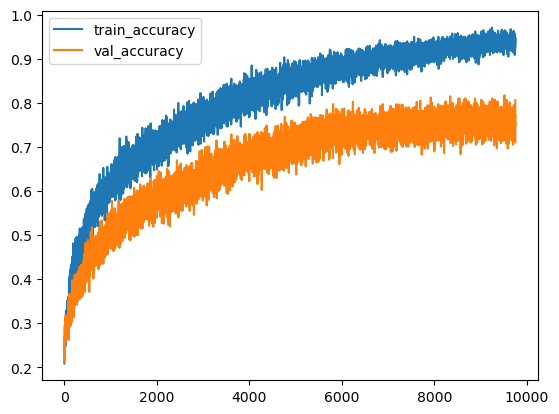

In [78]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
df1 = pd.DataFrame(results["train_acc_list"],columns=['train_accuracy'])
df2 = pd.DataFrame([i for i in results["val_acc_list"]],columns=['val_accuracy'])
df = pd.concat([df1,df2],axis=1)
df.plot()

<Axes: >

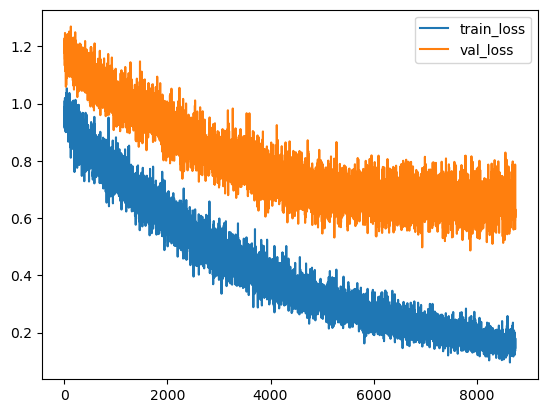

In [79]:
df1 = pd.DataFrame(results["train_loss_list"][1000:],columns=['train_loss'])
df2 = pd.DataFrame([i for i in results["val_loss_list"][1000:]],columns=['val_loss'])
df = pd.concat([df1,df2],axis=1)
df.plot()

# Testing

In [ ]:
pred_res = test(embedding,cls_head, test_data, loss_func, device)
df = pd.concat([pd.Series(range(15000)),pd.Series(pred_res)],axis = 1)
df = df.rename(columns={df.columns[0]:"Id",df.columns[1]:"Category"})
df.to_csv("submission_R2D2.csv", index =False)

In [289]:
for i in range(3):
    model_param=f"./model/resnet_task_augmentation/model_{8000+500*i}.pt"

    model = l2l.vision.models.ResNet12(output_size=ways).to(device)
    meta_model = l2l.algorithms.MAML(model, lr=maml_lr,first_order=False)
    param = torch.load(model_param)
    
    meta_model.load_state_dict(param)
    meta_model = meta_model.to(device)
    meta_model.eval()
    pred_res = test(meta_model, test_data, loss_func, device)
    df = pd.concat([pd.Series(range(15000)),pd.Series(pred_res)],axis = 1)
    df = df.rename(columns={df.columns[0]:"Id",df.columns[1]:"Category"})
    df.to_csv(f"submission_{7500+500*i}.csv", index =False)

100%|████████████████████████| 600/600 [00:27<00:00, 21.71it/s]


In [80]:
model_param=f"./model/resnet_task_augmentation/final_model.pt"

model = l2l.vision.models.ResNet12(output_size=ways).to(device)
meta_model = l2l.algorithms.MAML(model, lr=maml_lr,first_order=False)
param = torch.load(model_param)

meta_model.load_state_dict(param)
meta_model = meta_model.to(device)
meta_model.eval()
pred_res = test(meta_model, test_data, loss_func, device)
df = pd.concat([pd.Series(range(15000)),pd.Series(pred_res)],axis = 1)
df = df.rename(columns={df.columns[0]:"Id",df.columns[1]:"Category"})
df.to_csv(f"submission_final.csv", index =False)

NameError: name 'test' is not defined

In [83]:
meta_model.eval()
pred_res = test(meta_model, test_data, loss_func, device)
df = pd.concat([pd.Series(range(15000)),pd.Series(pred_res)],axis = 1)
df = df.rename(columns={df.columns[0]:"Id",df.columns[1]:"Category"})
df.to_csv("submission_final.csv", index =False)

100%|████████████████████████| 600/600 [00:27<00:00, 22.11it/s]


In [29]:
logits = torch.tensor([[1.0773e+11, 7.5959e+10, 9.5308e+10, 9.5373e+10, 8.2082e+10],
        [1.0872e+11, 7.7008e+10, 9.7003e+10, 9.7210e+10, 8.2911e+10],
        [1.3146e+11, 8.9390e+10, 1.1798e+11, 1.1846e+11, 9.5987e+10],
        [9.6601e+10, 6.8279e+10, 8.6316e+10, 8.6446e+10, 7.3083e+10],
        [1.5807e+11, 1.0857e+11, 1.4200e+11, 1.4148e+11, 1.1695e+11],
        [1.9288e+11, 1.3134e+11, 1.7155e+11, 1.7217e+11, 1.4263e+11],
        [8.0842e+10, 5.6430e+10, 7.3589e+10, 7.3264e+10, 5.9902e+10],
        [8.9487e+10, 6.3348e+10, 8.0035e+10, 8.0303e+10, 6.7513e+10],
        [9.1129e+10, 6.4436e+10, 8.1607e+10, 8.1385e+10, 6.8834e+10],
        [1.3238e+11, 8.9931e+10, 1.2053e+11, 1.1930e+11, 9.6356e+10],
        [7.1343e+10, 5.1808e+10, 6.2693e+10, 6.3131e+10, 5.5865e+10],
        [9.5055e+10, 6.7091e+10, 8.5261e+10, 8.5491e+10, 7.1819e+10],
        [1.2407e+11, 8.5590e+10, 1.1115e+11, 1.1158e+11, 9.2132e+10],
        [1.0568e+11, 7.3634e+10, 9.5151e+10, 9.5010e+10, 7.9253e+10],
        [1.1085e+11, 7.6870e+10, 1.0025e+11, 9.9342e+10, 8.2713e+10],
        [1.4068e+11, 9.7320e+10, 1.2621e+11, 1.2581e+11, 1.0432e+11],
        [1.4971e+11, 1.0320e+11, 1.3305e+11, 1.3250e+11, 1.1204e+11],
        [9.9841e+10, 6.9068e+10, 8.9609e+10, 8.9962e+10, 7.4221e+10],
        [1.1739e+11, 8.1278e+10, 1.0460e+11, 1.0525e+11, 8.7834e+10],
        [1.1226e+11, 7.6731e+10, 1.0142e+11, 1.0131e+11, 8.2174e+10],
        [1.3801e+11, 9.5380e+10, 1.2355e+11, 1.2435e+11, 1.0241e+11],
        [2.4232e+11, 1.6236e+11, 2.1895e+11, 2.1657e+11, 1.7662e+11],
        [1.0592e+11, 7.4917e+10, 9.4161e+10, 9.4877e+10, 8.0816e+10],
        [1.9733e+11, 1.3240e+11, 1.7805e+11, 1.7661e+11, 1.4313e+11],
        [1.0051e+11, 7.0930e+10, 9.0287e+10, 9.0371e+10, 7.6299e+10],
        [9.8819e+10, 6.9744e+10, 8.8567e+10, 8.8700e+10, 7.4947e+10],
        [6.3783e+10, 4.6203e+10, 5.7181e+10, 5.7600e+10, 4.8943e+10],
        [1.0337e+11, 7.3024e+10, 9.1732e+10, 9.2028e+10, 7.9126e+10],
        [8.5237e+10, 6.0404e+10, 7.5636e+10, 7.6461e+10, 6.4740e+10],
        [1.3051e+11, 8.9346e+10, 1.1654e+11, 1.1686e+11, 9.6425e+10]])
label =torch.tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4]).long()
# nn.CrossEntropyLoss(logits,label)

In [35]:
nn.CrossEntropyLoss()(logits,label)

tensor(1.5954e+10)